# This is the pipeline using only libraries

In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import seaborn as sns 
import pandas as pd

from scipy import sparse
from scipy.sparse import csr_matrix

import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt

import models as m
import utils as u

from surprise.dataset import * 
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import accuracy
from surprise.model_selection import GridSearchCV
%load_ext autoreload
%autoreload 2

## Load data

In [2]:
raw_data = pd.read_csv('data/data_train.csv', header=0, index_col=0, names=['Id', 'rating'])

df = u.preprocess(raw_data).reset_index().drop(columns=['Id'])

# Data Analysis

In [3]:
df.describe()

,rating,user,item
count,1.048575e+06,1.048575e+06,1.048575e+06
mean,3.892523e+00,5.149863e+03,4.301103e+02
std,1.106656e+00,2.919123e+03,2.402626e+02
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,3.000000e+00,2.604000e+03,2.160000e+02
50%,4.000000e+00,5.245000e+03,4.500000e+02
75%,5.000000e+00,7.736000e+03,6.400000e+02
max,5.000000e+00,1.000000e+04,8.340000e+02


In [4]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.item)))

Total data 
--------------------------------------------------

Total no of ratings : 1048575
Total No of Users   : 10000
Total No of movies  : 834


In [5]:
df.head()

,rating,user,item
0,4,44,1
1,3,61,1
2,4,67,1
3,3,72,1
4,5,86,1


## Number of rating per user

In [6]:
number_of_rating_per_user = df.groupby("user").count().rating.sort_values(ascending=False)
number_of_rating_per_user.describe()

count    10000.000000
mean       104.857500
std         59.048201
min          2.000000
25%         61.000000
50%         94.000000
75%        137.000000
max        433.000000
Name: rating, dtype: float64

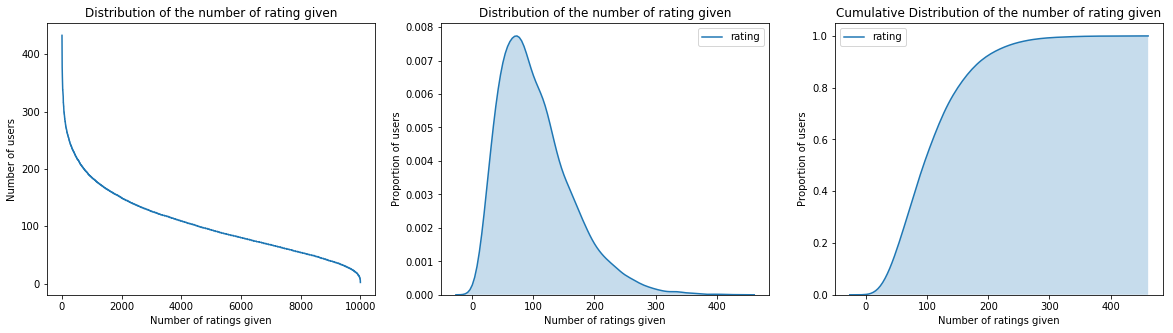

In [7]:
plt.figure(figsize=(20,5))

plt.subplot(131)
plt.plot(number_of_rating_per_user.values)
plt.title('Distribution of the number of rating given')
plt.xlabel('Number of ratings given')
plt.ylabel('Number of users')

plt.subplot(132)
sns.kdeplot(number_of_rating_per_user, shade=True)
plt.title('Distribution of the number of rating given')
plt.xlabel('Number of ratings given')
plt.ylabel('Proportion of users')

plt.subplot(133)
sns.kdeplot(number_of_rating_per_user, shade=True,cumulative=True,)
plt.title('Cumulative Distribution of the number of rating given')
plt.xlabel('Number of ratings given')
plt.ylabel('Proportion of users')

plt.show()

##  Number of rating per movie

In [8]:
number_of_rating_per_movie = df.groupby("item").count().rating.sort_values(ascending=False)
number_of_rating_per_movie.describe()

count     834.000000
mean     1257.284173
std       967.608495
min        27.000000
25%       528.000000
50%       965.000000
75%      1743.750000
max      4590.000000
Name: rating, dtype: float64

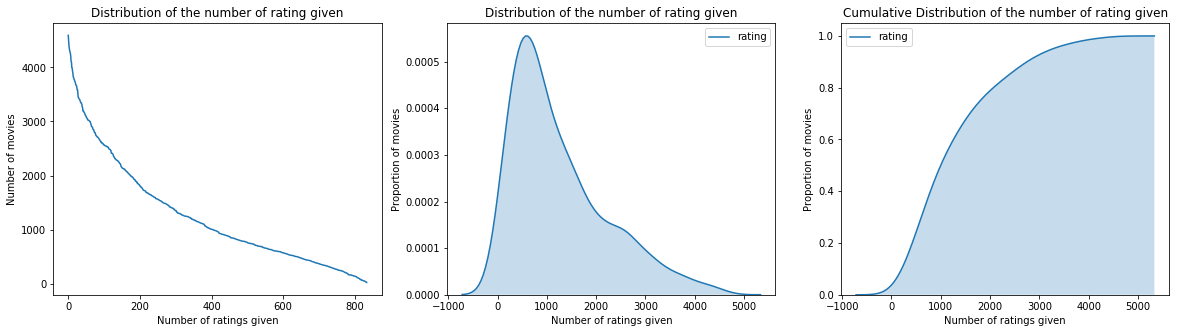

In [9]:
plt.figure(figsize=(20,5))

plt.subplot(131)
plt.plot(number_of_rating_per_movie.values);
plt.title('Distribution of the number of rating given')
plt.xlabel('Number of ratings given')
plt.ylabel('Number of movies')

plt.subplot(132)
sns.kdeplot(number_of_rating_per_movie, shade=True)
plt.title('Distribution of the number of rating given')
plt.xlabel('Number of ratings given')
plt.ylabel('Proportion of movies')

plt.subplot(133)
sns.kdeplot(number_of_rating_per_movie, shade=True,cumulative=True,)
plt.title('Cumulative Distribution of the number of rating given')
plt.xlabel('Number of ratings given')
plt.ylabel('Proportion of movies')

plt.show()

Text(0,0.5,'Number of rating')

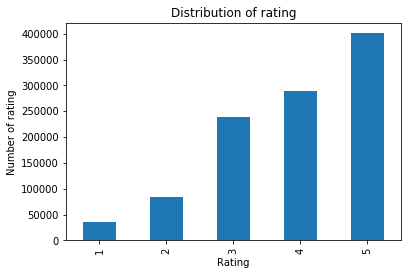

In [10]:
df.groupby('rating').count().user.plot.bar()
plt.title('Distribution of rating')
plt.xlabel('Rating')
plt.ylabel('Number of rating')

## Sparse Matrix 

In [11]:
sparse_matrix = sparse.csr_matrix((df.rating.values, (df.user.values-1 ,df.item.values-1)))
print('Matrix shape is : (user, movie) : ',sparse_matrix.shape)

Matrix shape is : (user, movie) :  (10000, 834)


Put -1 because we have movie and user numbers start at 1 and not 0 

In [12]:
users, movies = sparse_matrix.shape
elem = sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {0} % ".format((1 - (elem / (users * movies))) * 100))

Sparsity Of Train matrix : 87.4271582733813 % 


## Rating's averages

### Rating's average over all data

In [13]:
global_average = sparse_matrix.sum() / sparse_matrix.count_nonzero()
print("The average rating over all movies is : {0} ".format(global_average) )

The average rating over all movies is : 3.892522709391317 


### Rating's average per user

In [14]:
user_mean = []   #contains the mean rating for user i at index i

for user_index in range(users):
    
        # find the non-zero ratings for each user in the dataset
        ratings = sparse_matrix[user_index, :]
        nonzeros_ratings = ratings[ratings.nonzero()]
        
        # calculate the mean if the number of elements is not 0
        if nonzeros_ratings.shape[1] != 0:
            user_mean.append(nonzeros_ratings.mean())
        else:
            user_mean.append(0)

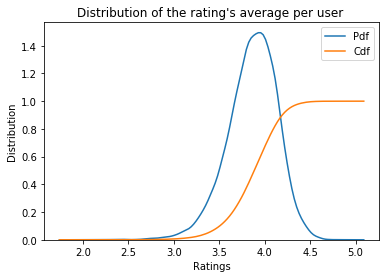

In [15]:
plt.figure()

sns.distplot(user_mean, hist=False,label='Pdf')
sns.distplot(user_mean,hist=False, kde_kws=dict(cumulative=True), label='Cdf')

plt.title("Distribution of the rating's average per user ")
plt.xlabel('Ratings')
plt.ylabel('Distribution')

plt.show()

### Rating's average per movie

In [16]:
movie_mean = []   #contains the mean rating for movie j at index j

for movie_index in range(movies):
    
        # find the non-zero ratings for each user in the dataset
        ratings = sparse_matrix[:, movie_index]
        nonzeros_ratings = ratings[ratings.nonzero()]
        
        # calculate the mean if the number of elements is not 0
        if nonzeros_ratings.shape[1] != 0:
            movie_mean.append(nonzeros_ratings.mean())
        else:
            movie_mean.append(0)

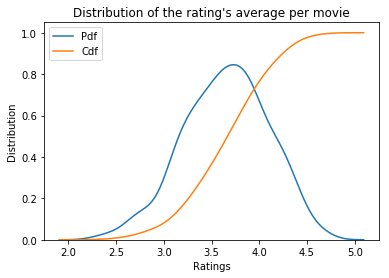

In [17]:
plt.figure()

sns.distplot(movie_mean, hist=False,label='Pdf')
sns.distplot(movie_mean,hist=False, kde_kws=dict(cumulative=True), label='Cdf')

plt.title("Distribution of the rating's average per movie")
plt.xlabel('Ratings')
plt.ylabel('Distribution')

plt.show()

### Similarity Matrix 

In [63]:
from sklearn.metrics.pairwise import cosine_similarity

# get the indices of  non zero rows(users) from our sparse matrix
row_ind, col_ind = sparse_matrix.nonzero()

row_ind = sorted(set(row_ind))   #to have unique values and sorted if needed  
col_ind = sorted(set(col_ind))

In [64]:
len(col_ind)

834

#### User-User similarity 

In [25]:
top = 5 
print("Computing top",top,"similarities for each user")

Computing top 5 similarities for each user


In [41]:
user_simil_matrix = []

for row in row_ind: 
    if (row % 1000 == 0):   #to observe the progression as I wait...
        print(row)
        
    # get the similarity row for this user with all other users
    simil = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
    
    # get the index of the top 5 
    top_users = np.argsort((simil))[::-1][1:top+1]
    user_simil_matrix.append(top_users)
print("Saving it to disk without the need of re-computing it again.. ")
np.savetxt("sim_matrix_user_user.txt", user_simil_matrix)
print("Done..")

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
Saving it to disk without the need of re-computing it again.. 
Done..


In [123]:
user_simil_matrix= np.loadtxt("sim_matrix_user_user.txt")
user_simil_matrix

array([[8744., 2649., 2908., 8962., 8367.],
       [7207., 1230., 6780., 2928., 5532.],
       [ 842., 6061., 9924., 1555., 7928.],
       ...,
       [1448., 2774., 1679., 2657., 8170.],
       [5108., 7253., 3210., 3022., 8945.],
       [6615.,  867., 3465., 3809., 1548.]])

#### Movie-Movie similarity

In [ ]:
top = 5 
print("Computing top",top,"similarities for each movie")

In [60]:
movie_simil_matrix = cosine_similarity(sparse_matrix.T, dense_output=False)  #if no y's it's pairwise sim  between the row that are movie

In [94]:
movie_simil_matrix = []

for col in col_ind: 
    if (col % 100 == 0):   #to observe the progression as I wait...
        print(col)
    
    # get the similarity col for this movie with all other movies
    simil = cosine_similarity(sparse_matrix.getcol(col).T, sparse_matrix.T).ravel()
    # get the index of the top 5 
    top_movies = np.argsort((simil))[::-1][1:top+1]
    movie_simil_matrix.append(top_movies)

print("Saving it to disk without the need of re-computing it again.. ")
np.savetxt("sim_matrix_movie_movie.txt", movie_simil_matrix)
print("Done..")

0
100
200
300
400
500
600
700
800
Saving it to disk without the need of re-computing it again.. 
Done..


In [95]:
movie_simil_matrix =  np.loadtxt("sim_matrix_movie_movie.txt")
movie_simil_matrix

array([[ 52., 801., 336.,  76., 198.],
       [484., 535., 807., 659., 173.],
       [105., 699., 750., 790., 439.],
       ...,
       [705., 809.,  13., 546., 349.],
       [457., 256.,  13., 349.,  59.],
       [705., 155., 778., 496., 133.]])

### Featurizing data

GAvg : Average rating of all the ratings
    
Similar users rating of this movie:
sur1, sur2, sur3, sur4, sur5 ( top 5 similar users who rated that movie.. )

Similar movies rated by this user:
smr1, smr2, smr3, smr4, smr5 ( top 5 similar movies rated by this movie.. )

UAvg : User's Average rating
    
MAvg : Average rating of this movie
    
rating : Rating of this movie by this user.

In [238]:
row_ind, col_ind = sparse_matrix.nonzero()

In [342]:
df_featured_data = pd.DataFrame({'User': row_ind, 'Movie' : col_ind, 'Grade' : sparse_matrix.data, 'Global_Average' : global_average })

In [343]:
df_featured_data.head()

,User,Movie,Grade,Global_Average
0,0,9,5,3.892523
1,0,60,5,3.892523
2,0,67,4,3.892523
3,0,83,4,3.892523
4,0,205,2,3.892523


In [344]:
df_featured_data['User_Average'] = df_featured_data['User'].map(lambda x: user_mean[x])
df_featured_data['Movie_Average'] = df_featured_data['Movie'].map(lambda x: movie_mean[x])

In [346]:
df_featured_data.head()

,User,Movie,Grade,Global_Average,User_Average,Movie_Average
0,0,9,5,3.892523,4.2,3.646072
1,0,60,5,3.892523,4.2,3.884834
2,0,67,4,3.892523,4.2,3.505051
3,0,83,4,3.892523,4.2,4.175318
4,0,205,2,3.892523,4.2,3.974499


Get the indices of the similar users

In [347]:
df_featured_data['SimUser1'] = df_featured_data['User'].map(lambda x: int(user_simil_matrix[x][0]))
df_featured_data['SimUser2'] = df_featured_data['User'].map(lambda x: int(user_simil_matrix[x][1]))
df_featured_data['SimUser3'] = df_featured_data['User'].map(lambda x: int(user_simil_matrix[x][2]))
df_featured_data['SimUser4'] = df_featured_data['User'].map(lambda x: int(user_simil_matrix[x][3]))
df_featured_data['SimUser5'] = df_featured_data['User'].map(lambda x: int(user_simil_matrix[x][4]))

In [489]:
df_featured_data.head()

,User,Movie,Grade,Global_Average,User_Average,Movie_Average,SimUser1,SimUser2,SimUser3,SimUser4,SimUser5,SimMovie1,SimMovie2,SimMovie3,SimMovie4,SimMovie5
0,0,9,5,3.892523,4.2,3.646072,8744,2649,2908,8962,8367,4.668212,4.682770,4.639421,4.446219,5.000000
1,0,60,5,3.892523,4.2,3.884834,8744,2649,2908,8962,8367,4.682035,5.000000,4.726254,4.354707,4.424486
2,0,67,4,3.892523,4.2,3.505051,8744,2649,2908,8962,8367,4.561553,4.668212,4.125744,3.953674,4.448840
3,0,83,4,3.892523,4.2,4.175318,8744,2649,2908,8962,8367,4.048102,4.358686,4.486889,4.239246,4.561553
4,0,205,2,3.892523,4.2,3.974499,8744,2649,2908,8962,8367,4.668212,4.345068,4.493464,4.365132,4.561553


For each similar user need to find the rating that he put for that movie if not available put the average rating of that user as an estimator. 

In [490]:
def Userfunction1(row):
    if(sparse_matrix[row['SimUser1'],row['Movie']] == 0):
        return user_mean[int(row['SimUser1'])]
    else:
        return sparse_matrix[row['SimUser1'],row['Movie']]

In [491]:
df_featured_data['SimUser1'] = df_featured_data.apply(Userfunction1,axis=1)

In [492]:
def Userfunction2(row):
    if(sparse_matrix[row['SimUser2'],row['Movie']] == 0):
        return user_mean[int(row['SimUser2'])]
    else:
        return sparse_matrix[row['SimUser2'],row['Movie']]

In [493]:
df_featured_data['SimUser2'] = df_featured_data.apply(Userfunction2,axis=1)

In [494]:
def Userfunction3(row):
    if(sparse_matrix[row['SimUser3'],row['Movie']] == 0):
        return user_mean[int(row['SimUser3'])]
    else:
        return sparse_matrix[row['SimUser3'],row['Movie']]

In [495]:
df_featured_data['SimUser3'] = df_featured_data.apply(Userfunction3,axis=1)

In [496]:
def Userfunction4(row):
    if(sparse_matrix[row['SimUser4'],row['Movie']] == 0):
        return user_mean[int(row['SimUser4'])]
    else:
        return sparse_matrix[row['SimUser4'],row['Movie']]

In [497]:
df_featured_data['SimUser4'] = df_featured_data.apply(Userfunction4,axis=1)

In [498]:
def Userfunction5(row):
    if(sparse_matrix[row['SimUser5'],row['Movie']] == 0):
        return user_mean[int(row['SimUser5'])]
    else:
        return sparse_matrix[row['SimUser5'],row['Movie']]

In [499]:
df_featured_data['SimUser5'] = df_featured_data.apply(Userfunction5,axis=1)

In [500]:
df_featured_data

,User,Movie,Grade,Global_Average,User_Average,Movie_Average,SimUser1,SimUser2,SimUser3,SimUser4,SimUser5,SimMovie1,SimMovie2,SimMovie3,SimMovie4,SimMovie5
0,0,9,5,3.892523,4.200000,3.646072,5.000000,3.837209,4.148515,3.958333,4.100000,4.668212,4.682770,4.639421,4.446219,5.000000
1,0,60,5,3.892523,4.200000,3.884834,3.000000,4.000000,4.148515,5.000000,4.100000,4.682035,5.000000,4.726254,4.354707,4.424486
2,0,67,4,3.892523,4.200000,3.505051,3.966667,3.837209,3.000000,3.958333,4.000000,4.561553,4.668212,4.125744,3.953674,4.448840
3,0,83,4,3.892523,4.200000,4.175318,3.966667,3.837209,3.000000,4.000000,4.100000,4.048102,4.358686,4.486889,4.239246,4.561553
4,0,205,2,3.892523,4.200000,3.974499,3.966667,3.837209,4.148515,3.958333,4.100000,4.668212,4.345068,4.493464,4.365132,4.561553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,9999,768,3,3.892523,4.030612,4.183138,4.000000,3.966667,3.818182,5.000000,5.000000,4.443052,4.000000,4.327196,4.000000,4.206940
1048571,9999,790,4,3.892523,4.030612,4.243106,5.000000,3.966667,3.818182,4.225166,5.000000,2.000000,5.000000,4.493464,4.691840,4.726254
1048572,9999,791,5,3.892523,4.030612,4.235588,4.105882,5.000000,5.000000,5.000000,5.000000,5.000000,4.410410,4.493441,4.448840,2.000000
1048573,9999,793,3,3.892523,4.030612,3.903812,4.105882,3.966667,3.818182,4.225166,3.000000,3.000000,4.394074,5.000000,4.000000,4.354707


Get the indices of the similar movies

In [366]:
df_featured_data['SimMovie1'] = df_featured_data['Movie'].map(lambda x: int(movie_simil_matrix[x][0]))
df_featured_data['SimMovie2'] = df_featured_data['Movie'].map(lambda x: int(movie_simil_matrix[x][1]))
df_featured_data['SimMovie3'] = df_featured_data['Movie'].map(lambda x: int(movie_simil_matrix[x][2]))
df_featured_data['SimMovie4'] = df_featured_data['Movie'].map(lambda x: int(movie_simil_matrix[x][3]))
df_featured_data['SimMovie5'] = df_featured_data['Movie'].map(lambda x: int(movie_simil_matrix[x][4]))

In [367]:
df_featured_data.head()

,User,Movie,Grade,Global_Average,User_Average,Movie_Average,SimUser1,SimUser2,SimUser3,SimUser4,SimUser5,SimMovie1,SimMovie2,SimMovie3,SimMovie4,SimMovie5
0,0,9,5,3.892523,4.2,3.646072,5.000000,3.837209,4.148515,3.958333,4.1,155,5,607,45,595
1,0,60,5,3.892523,4.2,3.884834,5.000000,5.000000,4.148515,5.000000,4.1,593,595,255,433,13
2,0,67,4,3.892523,4.2,3.505051,3.966667,3.837209,4.000000,3.958333,4.0,59,155,88,284,610
3,0,83,4,3.892523,4.2,4.175318,3.966667,3.837209,4.000000,4.000000,4.1,546,250,190,160,59
4,0,205,2,3.892523,4.2,3.974499,3.966667,3.837209,4.148515,3.958333,4.1,155,294,177,494,59


For each similar movie we need to find the rating that the user has given to it if not available give the similar movie average rating.  

In [368]:
def Moviefunction1(row):
    if(sparse_matrix[row['User'],row['SimMovie1']] == 0):
        return movie_mean[int(row['SimMovie1'])]
    else:
        return sparse_matrix[row['User'],row['SimMovie1']]

In [369]:
df_featured_data['SimMovie1'] = df_featured_data.apply(Moviefunction1,axis=1)

In [370]:
def Moviefunction2(row):
    if(sparse_matrix[row['User'],row['SimMovie2']] == 0):
        return movie_mean[int(row['SimMovie2'])]
    else:
        return sparse_matrix[row['User'],row['SimMovie2']]

In [371]:
df_featured_data['SimMovie2'] = df_featured_data.apply(Moviefunction2,axis=1)

In [374]:
def Moviefunction3(row):
    if(sparse_matrix[row['User'],row['SimMovie3']] == 0):
        return movie_mean[int(row['SimMovie3'])]
    else:
        return sparse_matrix[row['User'],row['SimMovie3']]

In [375]:
df_featured_data['SimMovie3'] = df_featured_data.apply(Moviefunction3,axis=1)

In [376]:
def Moviefunction4(row):
    if(sparse_matrix[row['User'],row['SimMovie4']] == 0):
        return movie_mean[int(row['SimMovie4'])]
    else:
        return sparse_matrix[row['User'],row['SimMovie4']]

In [377]:
df_featured_data['SimMovie4'] = df_featured_data.apply(Moviefunction4,axis=1)

In [378]:
def Moviefunction5(row):
    if(sparse_matrix[row['User'],row['SimMovie5']] == 0):
        return movie_mean[int(row['SimMovie5'])]
    else:
        return sparse_matrix[row['User'],row['SimMovie5']]

In [379]:
df_featured_data['SimMovie5'] = df_featured_data.apply(Moviefunction5,axis=1)

We finnaly get the following dataframe with 13 features

In [501]:
df_featured_data

,User,Movie,Grade,Global_Average,User_Average,Movie_Average,SimUser1,SimUser2,SimUser3,SimUser4,SimUser5,SimMovie1,SimMovie2,SimMovie3,SimMovie4,SimMovie5
0,0,9,5,3.892523,4.200000,3.646072,5.000000,3.837209,4.148515,3.958333,4.100000,4.668212,4.682770,4.639421,4.446219,5.000000
1,0,60,5,3.892523,4.200000,3.884834,3.000000,4.000000,4.148515,5.000000,4.100000,4.682035,5.000000,4.726254,4.354707,4.424486
2,0,67,4,3.892523,4.200000,3.505051,3.966667,3.837209,3.000000,3.958333,4.000000,4.561553,4.668212,4.125744,3.953674,4.448840
3,0,83,4,3.892523,4.200000,4.175318,3.966667,3.837209,3.000000,4.000000,4.100000,4.048102,4.358686,4.486889,4.239246,4.561553
4,0,205,2,3.892523,4.200000,3.974499,3.966667,3.837209,4.148515,3.958333,4.100000,4.668212,4.345068,4.493464,4.365132,4.561553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,9999,768,3,3.892523,4.030612,4.183138,4.000000,3.966667,3.818182,5.000000,5.000000,4.443052,4.000000,4.327196,4.000000,4.206940
1048571,9999,790,4,3.892523,4.030612,4.243106,5.000000,3.966667,3.818182,4.225166,5.000000,2.000000,5.000000,4.493464,4.691840,4.726254
1048572,9999,791,5,3.892523,4.030612,4.235588,4.105882,5.000000,5.000000,5.000000,5.000000,5.000000,4.410410,4.493441,4.448840,2.000000
1048573,9999,793,3,3.892523,4.030612,3.903812,4.105882,3.966667,3.818182,4.225166,3.000000,3.000000,4.394074,5.000000,4.000000,4.354707


We save the dataframe computed

In [502]:
file_name = 'featured_data.pk'
df_featured_data.to_pickle(file_name)  

# XGB with 13 features

### Training

In [503]:
df = pd.read_pickle(file_name)

In [504]:
import xgboost as xgb

In [505]:
def error_metrics(true,pred):
    rmse = np.sqrt(np.mean([ (true[i] - pred[i])**2 for i in range(len(pred)) ]))
    mape = np.mean(np.abs( (true-pred)/true ))*100
    return rmse, mape

In [506]:
algo = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=1, n_estimators=100)

x_train= df.drop(['User','Movie','Grade'],axis=1)
y_train= df['Grade']

algo.fit(x_train, y_train, eval_metric = 'rmse')
y_train_pred = algo.predict(x_train)
rmse_train, mape_train = error_metrics(y_train.values, y_train_pred)
train_r = {'rmse': rmse_train,'mape' : mape_train,'predictions' : y_train_pred}

C:\Users\Ridha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Ridha\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:08:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [507]:
train_r

{'rmse': 0.9649037962541899,
 'mape': 27.94645721556277,
 'predictions': array([3.981151 , 4.246266 , 3.7017262, ..., 4.5438004, 3.802572 ,
        3.5928674], dtype=float32)}

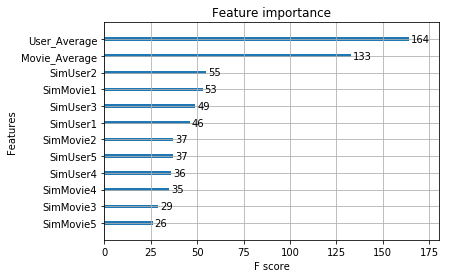

In [508]:
xgb.plot_importance(algo)
plt.show()

### Prediciton

We read the data and put it in a sparse matrix

In [606]:
ids, users , movies=  u.read_file()

In [460]:
pred_users_set = sorted(set(users))

In [458]:
pred_movies_set = sorted(set(movies))

In [449]:
print( "In submission file we have {0} users and {1} movies".format(len(set(users)),len(set(movies))))

In submission file we have 10000 users and 1000 movies


In [510]:
max(pred_users_set)

9999

In [459]:
pred_users_set.difference(row_ind)

set()

In [512]:
new_movies = pred_movies_set.difference(col_ind)
len(new_movies)

166

We have to predict ratings for movies that are not in our training set 

Featurizing the data

In [450]:
df_sub = pd.DataFrame({"User" : users, "Movie" : movies, "Global_Average" : global_average})

In [451]:
df_sub.head()

,User,Movie,Global_Average
0,36,0,3.892523
1,72,0,3.892523
2,155,0,3.892523
3,159,0,3.892523
4,247,0,3.892523


In [462]:
df_sub['User_Average'] = df_sub['User'].map(lambda x: user_mean[x])

In [514]:
def movie_average_function(row):
    if(row.Movie not in new_movies):
        return movie_mean[int(row.Movie)]
    else: 
        return global_average    #if we don't know the movie we put the average rating 

In [515]:
df_sub['Movie_Average'] = df_sub.apply(movie_average_function, axis=1)

In [516]:
df_sub.head()

,User,Movie,Global_Average,User_Average,Movie_Average,SimUser1,SimUser2,SimUser3,SimUser4,SimUser5
0,36,0,3.892523,3.732558,3.379412,3129,7951,3819,9538,8531
1,72,0,3.892523,3.539326,3.379412,4933,4,6852,8338,8051
2,155,0,3.892523,4.276860,3.379412,5901,6100,9406,823,2889
3,159,0,3.892523,3.746212,3.379412,5288,999,1984,5855,742
4,247,0,3.892523,3.899329,3.379412,5848,2356,5307,3227,5705


We get the user that are similar 

In [480]:
df_sub['SimUser1'] = df_sub['User'].map(lambda x: int(user_simil_matrix[x][0]))
df_sub['SimUser2'] = df_sub['User'].map(lambda x: int(user_simil_matrix[x][1]))
df_sub['SimUser3'] = df_sub['User'].map(lambda x: int(user_simil_matrix[x][2]))
df_sub['SimUser4'] = df_sub['User'].map(lambda x: int(user_simil_matrix[x][3]))
df_sub['SimUser5'] = df_sub['User'].map(lambda x: int(user_simil_matrix[x][4]))

In [482]:
df_sub.head()

,User,Movie,Global_Average,User_Average,Movie_Average,SimUser1,SimUser2,SimUser3,SimUser4,SimUser5
0,36,0,3.892523,3.732558,3.379412,3129,7951,3819,9538,8531
1,72,0,3.892523,3.539326,3.379412,4933,4,6852,8338,8051
2,155,0,3.892523,4.276860,3.379412,5901,6100,9406,823,2889
3,159,0,3.892523,3.746212,3.379412,5288,999,1984,5855,742
4,247,0,3.892523,3.899329,3.379412,5848,2356,5307,3227,5705


For each similar user need to find the rating that he put for that movie if not available put the average rating of that user as an estimator. 

In [520]:
def PredUserfunction1(row):
    if(row.Movie in new_movies or sparse_matrix[row['SimUser1'],row['Movie']] == 0):
        return user_mean[int(row['SimUser1'])]
    else:
        return sparse_matrix[row['SimUser1'],row['Movie']]

In [521]:
df_sub['SimUser1'] = df_sub.apply(PredUserfunction1,axis=1)

In [522]:
def PredUserfunction2(row):
    if(row.Movie in new_movies or sparse_matrix[row['SimUser2'],row['Movie']] == 0):
        return user_mean[int(row['SimUser2'])]
    else:
        return sparse_matrix[row['SimUser2'],row['Movie']]

In [523]:
df_sub['SimUser2'] = df_sub.apply(PredUserfunction2,axis=1)

In [524]:
def PredUserfunction3(row):
    if(row.Movie in new_movies or sparse_matrix[row['SimUser3'],row['Movie']] == 0):
        return user_mean[int(row['SimUser3'])]
    else:
        return sparse_matrix[row['SimUser3'],row['Movie']]

In [525]:
df_sub['SimUser3'] = df_sub.apply(PredUserfunction3,axis=1)

In [528]:
def PredUserfunction4(row):
    if(row.Movie in new_movies or sparse_matrix[row['SimUser4'],row['Movie']] == 0):
        return user_mean[int(row['SimUser4'])]
    else:
        return sparse_matrix[row['SimUser4'],row['Movie']]

In [529]:
df_sub['SimUser4'] = df_sub.apply(PredUserfunction4,axis=1)

In [530]:
def PredUserfunction5(row):
    if(row.Movie in new_movies or sparse_matrix[row['SimUser5'],row['Movie']] == 0):
        return user_mean[int(row['SimUser5'])]
    else:
        return sparse_matrix[row['SimUser5'],row['Movie']]

In [531]:
df_sub['SimUser5'] = df_sub.apply(PredUserfunction5,axis=1)

In [ ]:
df_sub.head()

We now get the movies that are similar but here we have the problem that we have missing movies sometimes so we put the average rating as an estimator. 

In [544]:
def movie_function1(row):
    if(row.Movie in new_movies):   #if new_movie
        return global_average
    else:
        
        index_movie1 = int(movie_simil_matrix[int(row.Movie)][0])   #get index of similar movie
        
        if(sparse_matrix[row['User'],index_movie1] == 0):     #if not graded by the user give the movie mean rating
            return movie_mean[index_movie1]
        else:                                                 #if graded by the user 
            return sparse_matrix[row['User'],index_movie1]  

In [545]:
df_sub['SimMovie1'] = df_sub.apply(movie_function1, axis=1)

In [548]:
def movie_function2(row):
    if(row.Movie in new_movies):   #if new_movie
        return global_average
    else:
        
        index_movie2 = int(movie_simil_matrix[int(row.Movie)][1])   #get index of similar movie
        
        if(sparse_matrix[row['User'],index_movie2] == 0):     #if not graded by the user give the movie mean rating
            return movie_mean[index_movie2]
        else:                                                 #if graded by the user 
            return sparse_matrix[row['User'],index_movie2]  

In [549]:
df_sub['SimMovie2'] = df_sub.apply(movie_function2, axis=1)

In [552]:
def movie_function3(row):
    if(row.Movie in new_movies):   #if new_movie
        return global_average
    else:
        
        index_movie3 = int(movie_simil_matrix[int(row.Movie)][2])   #get index of similar movie
        
        if(sparse_matrix[row['User'],index_movie3] == 0):     #if not graded by the user give the movie mean rating
            return movie_mean[index_movie3]
        else:                                                 #if graded by the user 
            return sparse_matrix[row['User'],index_movie3]  

In [553]:
df_sub['SimMovie3'] = df_sub.apply(movie_function3, axis=1)

In [554]:
def movie_function4(row):
    if(row.Movie in new_movies):   #if new_movie
        return global_average
    else:
        
        index_movie4 = int(movie_simil_matrix[int(row.Movie)][3])   #get index of similar movie
        
        if(sparse_matrix[row['User'],index_movie4] == 0):     #if not graded by the user give the movie mean rating
            return movie_mean[index_movie4]
        else:                                                 #if graded by the user 
            return sparse_matrix[row['User'],index_movie4]  

In [558]:
df_sub['SimMovie4'] = df_sub.apply(movie_function4, axis=1)

In [556]:
def movie_function5(row):
    if(row.Movie in new_movies):   #if new_movie
        return global_average
    else:
        
        index_movie5 = int(movie_simil_matrix[int(row.Movie)][4])   #get index of similar movie
        
        if(sparse_matrix[row['User'],index_movie5] == 0):     #if not graded by the user give the movie mean rating
            return movie_mean[index_movie5]
        else:                                                 #if graded by the user 
            return sparse_matrix[row['User'],index_movie5]  

In [559]:
df_sub['SimMovie5'] = df_sub.apply(movie_function5, axis=1)

I save the data featurized

In [594]:
file_name_pred = 'featured_data_pred.pk'
df_sub.to_pickle(file_name_pred)  

In [595]:
df_sub_load= pd.read_pickle(file_name_pred)

In [596]:
df_sub_load.head()

,User,Movie,Global_Average,User_Average,Movie_Average,SimUser1,SimUser2,SimUser3,SimUser4,SimUser5,SimMovie1,SimMovie2,SimMovie3,SimMovie4,SimMovie5
0,36,0,3.892523,3.732558,3.379412,3.000000,3.537313,4.121739,3.000000,3.983193,4.000000,4.002893,3.971499,3.240566,3.240566
1,72,0,3.892523,3.539326,3.379412,3.775701,3.983193,3.587786,4.073913,4.157143,3.774063,4.002893,3.000000,3.240566,3.240566
2,155,0,3.892523,4.276860,3.379412,2.000000,4.150602,4.059925,4.251256,3.581522,4.000000,4.002893,3.000000,3.240566,3.240566
3,159,0,3.892523,3.746212,3.379412,4.000000,4.107817,4.464286,4.231023,4.000000,3.774063,4.002893,3.000000,3.240566,3.240566
4,247,0,3.892523,3.899329,3.379412,4.104265,3.000000,2.000000,4.307463,4.065934,3.774063,4.002893,3.971499,3.240566,3.240566


In [597]:
df_sub_load = df_sub_load.drop(['User','Movie'],axis =1 )

In [598]:
y_pred = algo.predict(df_sub_load)

In [603]:
y_pred_rounded = []
for i in y_pred:
    y_pred_rounded.append(int(round(i)))

In [608]:
u.create_csv_submission(ids,y_pred_rounded,"geralsucks.csv")

# Surprise

## Reader of Surprise

In [21]:
reader=Reader(rating_scale=(1.0,5.0))
formatted_data= Dataset.load_from_df(df[['user','item','rating']],reader)
trainset = formatted_data.build_full_trainset()

## Baseline

In [26]:
from surprise import BaselineOnly

sim_options = {'user_based' : False,'name': 'pearson_baseline','shrinkage': 100,'min_support': 2}
bo = {'method': 'sgd'}


bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }

algo = BaselineOnly(bsl_options=bsl_options)

algo.fit(trainset)

test_preds = algo.test(trainset.build_testset())

actual = np.array([pred.r_ui for pred in test_preds])
pred = np.array([pred.est for pred in test_preds])

rmse = np.sqrt(np.mean((pred - actual)**2))
mape = np.mean(np.abs(pred - actual)/actual)

print('\n\n Test ---rmse :{}  mape :{} '.format(rmse,mape))

# param_grid = {}
# gs = GridSearchCV(BaselineOnly, param_grid, measures=['rmse', 'mae'], cv=3,joblib_verbose=1, n_jobs=-1)
# gs.fit(trainset)
# print(gs.best_score['rmse'])

Estimating biases using sgd...


 Test ---rmse :0.9829492520266703  mape :0.28624346888312063 


In [27]:
ids, preds = u.predict_on_model(algo)
u.create_csv_submission(ids, preds, "submissionBase.csv")

## SVD

In [285]:
from surprise import SVD


algo = SVD(n_factors=1000, n_epochs=20, lr_all=0.005,reg_all=0.02)
cross_validate(algo, formatted_data, verbose=True,cv=3, measures=['RMSE', 'MAE'])# FOUND RMSE: 1.0276 locally


# param_grid = {'n_factors':[100,120],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
#               'reg_all': [0.4, 0.6]}
# gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3,joblib_verbose=1, n_jobs=-1)
# gs.fit(formatted_data)

# # best RMSE score
# print(gs.best_score['rmse'])

KeyboardInterrupt: 

In [ ]:
ids, preds = u.predict_on_model(algo)
u.create_csv_submission(ids, preds, "submissionSVD.csv")

## KNN on Movie

In [ ]:
from surprise import KNNBasic

algo =m.movie_knn()
cross_validate(algo, formatted_data, verbose=True,cv=3, measures=['RMSE', 'MAE']) # FOUND RMSE: 1.0603 locally, 1.133 online

# param_grid = {'n_neighbors':[3,5,9],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
#               'reg_all': [0.4, 0.6]}
# gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3,joblib_verbose=1, n_jobs=-1)
# gs.fit(formatted_data)

# # best RMSE score
# print(gs.best_score['rmse'])

In [ ]:
ids, preds = u.predict_on_model(algo)
u.create_csv_submission(ids, preds, "submissionKNNMovie.csv")

## KNN on User

### Surprise KNNBaseline with user user similarities

In [ ]:
from surprise import KNNBaseline

# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
 
knn_bsl_u.fit(trainset)

test_preds = knn_bsl_u.test(trainset.build_testset())

actual = np.array([pred.r_ui for pred in test_preds])
pred = np.array([pred.est for pred in test_preds])

rmse = np.sqrt(np.mean((pred - actual)**2))
mape = np.mean(np.abs(pred - actual)/actual)

print('\n\n Test ---rmse :{}  mape :{} '.format(rmse,mape))


# param_grid = {'n_neighbors':[3,5,9],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
#               'reg_all': [0.4, 0.6]}
# gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3,joblib_verbose=1, n_jobs=-1)
# gs.fit(formatted_data)

# # best RMSE score
# print(gs.best_score['rmse'])

Estimating biases using sgd...


In [ ]:
ids, preds = u.predict_on_model(knn_bsl_u)
u.create_csv_submission(ids, preds, "submissionKNNUser.csv")

## Slope One

In [ ]:
from surprise import SlopeOne

algo = SlopeOne()
cross_validate(algo, formatted_data, verbose=True,cv=5, measures=['RMSE', 'MAE'])# RMSE: 0.9923 locally, 1.143 online

# param_grid = {}
# gs = GridSearchCV(SlopeOne, param_grid, measures=['rmse', 'mae'], cv=3,joblib_verbose=1, n_jobs=-1)
# gs.fit(formatted_data)
# print(gs.best_score['rmse'])

In [ ]:
ids, preds = u.predict_on_model(algo)
u.create_csv_submission(ids, preds, "submissionSlopeOne.csv")

## CoClustering

In [4]:
algo = m.co_clustering()
cross_validate(algo, formatted_data, verbose=True,cv=5, measures=['RMSE', 'MAE'])# RMSE: 1.0038 locally, 1.140 online


Evaluating RMSE, MAE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0047  1.0040  1.0018  1.0041  1.0042  1.0038  0.0010  
MAE (testset)     0.8068  0.8071  0.8056  0.8067  0.8061  0.8065  0.0005  
Fit time          18.62   20.27   20.23   20.19   37.24   23.31   6.99    
Test time         2.09    2.19    1.83    4.71    3.64    2.89    1.11    


{'test_rmse': array([1.00471382, 1.00403069, 1.00179728, 1.00409181, 1.00423735]),
 'test_mae': array([0.80680981, 0.80712163, 0.80560541, 0.80666197, 0.80610796]),
 'fit_time': (18.623739004135132,
  20.274076223373413,
  20.233531713485718,
  20.189019918441772,
  37.243990659713745),
 'test_time': (2.0878589153289795,
  2.1923019886016846,
  1.833517074584961,
  4.712648868560791,
  3.6423721313476562)}

In [5]:
ids, preds = u.predict_on_model(algo)
u.create_csv_submission(ids, preds, "submissionCoClustering.csv")

# Blending

In [ ]:
t